In [9]:
import os.path
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data
import torchvision.utils
from torch import nn, optim
from torch.nn import functional
from torchvision import datasets, transforms

from PIL import Image
import umap
import umap.plot

In [2]:
class VAE(nn.Module):
    def __init__(self, input_shape, device, width, latent_dimensionality):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.n_input_values = np.prod(input_shape).item()
        self.device = device
        self.width = width
        self.latent_dimensionality = latent_dimensionality
 
        # Define encoding layers
        self.input_encoder = nn.Linear(self.n_input_values, self.width)
        self.mean_encoder = nn.Linear(self.width, self.latent_dimensionality)
        self.var_encoder = nn.Linear(self.width, self.latent_dimensionality)
 
        # Define decoding layers
        self.latent_decoder = nn.Linear(self.latent_dimensionality, self.width)
        self.final_decoder = nn.Linear(self.width, self.n_input_values)
 
    def encode(self, original):
        encoded_input = functional.relu(self.input_encoder(original))
        return (self.mean_encoder(encoded_input), self.var_encoder(encoded_input))
 
    def reparameterize(self, mean, log_variance):
        deviation = torch.exp(0.5 * log_variance)
        noise = torch.randn_like(deviation, device=self.device)
        return mean + noise * deviation
 
    def decode(self, latent):
        decoded_latent = functional.relu(self.latent_decoder(latent))
        final = self.final_decoder(decoded_latent)
        return final.view(-1, *self.input_shape)
 
    def forward(self, original):
        mean, log_variance = self.encode(original.view(-1, self.n_input_values))
        latent = self.reparameterize(mean, log_variance)
        decoded = self.decode(latent)
        return decoded, mean, log_variance
 
    def variational_loss_function(self, decoded, original, mean, log_variance) -> torch.Tensor:
        entropy = functional.mse_loss(decoded, original.view(-1, *self.input_shape), reduction="sum")
        divergence = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
        return entropy + divergence

In [16]:
def train_and_test(batch_size, width, latent_dimensionality, n_epochs, learning_rate, out_path, image_extension, max_saves_per_epoch):
    # Select GPU if available.
    device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
 
    # Set seed.
    torch.manual_seed(0)
 
    # Prepare data.
    train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST("data", train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST("data", train=False, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
 
    # Prepare batch to observe progress.
    fixed_batch, _ = next(iter(test_loader))
    grid = torchvision.utils.make_grid(fixed_batch)
    os.makedirs(out_path, exist_ok=True)
    path = os.path.join(out_path, f"original.{image_extension}")
    torchvision.utils.save_image(grid, path)
    fixed_batch = fixed_batch.to(device)
 
    # Prepare random latent to observe progress.
    fixed_latent = noise = torch.randn([batch_size, latent_dimensionality], device=device)
 
    # Prepare model.
    model = VAE(input_shape=fixed_batch.shape[1:], width=width, latent_dimensionality=latent_dimensionality, device=device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Save loss values for analysing
    loss_list = []
 
    # Process epochs.
    n_batches = len(train_loader)
    for i_epoch in range(n_epochs):
        model.train()
        n_save_batches = int((1 - i_epoch / n_epochs) * max_saves_per_epoch + 1)
        save_interval = int(n_batches / n_save_batches)
        epoch_losses = []
        # Train model.
        for i_batch, (batch, _) in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstruction, mean, log_variance = model(batch)
            loss = model.variational_loss_function(reconstruction, batch, mean, log_variance)
            epoch_losses.append(loss)
            loss.backward()
            optimizer.step()
 
            if i_batch % save_interval == 0:
                # Print progress.
                print(f"{i_epoch = }, {i_batch = }")
 
                # Process fixed batch.
                model.eval()
                reconstruction, _, _ = model(fixed_batch)
 
                grid = torchvision.utils.make_grid(reconstruction)
                path = os.path.join(out_path, f"reconstruction-{i_epoch:0{len(str(n_epochs))}}-{i_batch:0{len(str(n_batches))}}.{image_extension}")
                torchvision.utils.save_image(grid, path)
 
                # Process fixed latent.
                decoded = model.decode(fixed_latent)
 
                grid = torchvision.utils.make_grid(decoded)
                path = os.path.join(out_path, f'random-{i_epoch:0{len(str(n_epochs))}}-{i_batch:0{len(str(n_batches))}}.{image_extension}')
                torchvision.utils.save_image(grid, path)
        loss_list.append(epoch_losses)
    
    return model, loss_list

In [ ]:
vae_model, loss_list = train_and_test(batch_size=128, width=400, latent_dimensionality=20, n_epochs=20, learning_rate=1e-3, out_path="output", image_extension="png", max_saves_per_epoch=20)

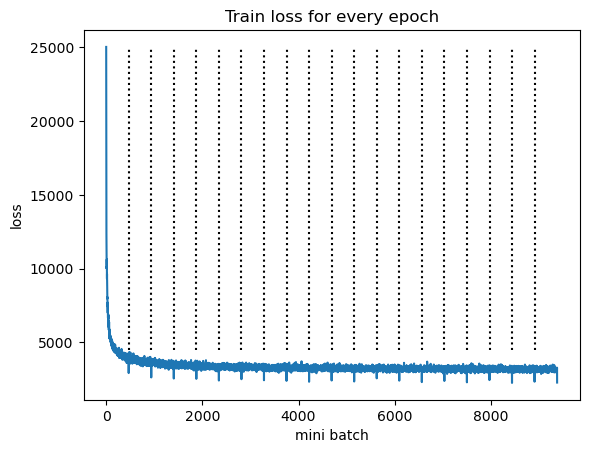

In [33]:
pd.Series(torch.Tensor(loss_list).view(20*469)).plot()
plt.vlines([469*i+469 for i in range(19)], 4500, 25000, colors='k', linestyles='dotted')
plt.title('Train loss for every epoch')
plt.xlabel('mini batch')
plt.ylabel('loss')
plt.show();

## Part 1

Original


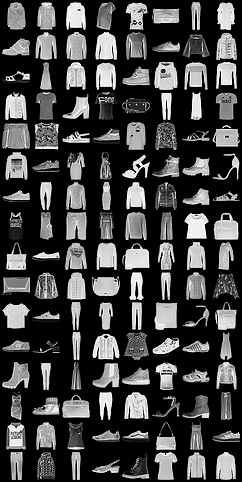

Reconstruction


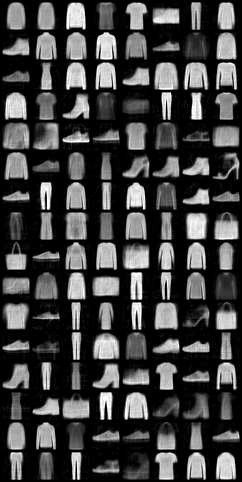

Random


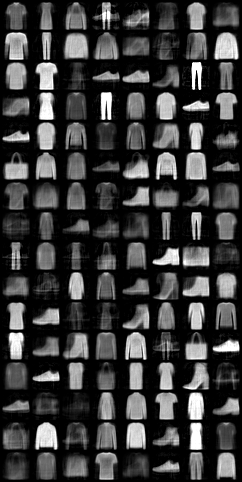

In [15]:
print('Original')
with open('output/original.png', 'rb') as f:
    display(Image.open(f))
print('Reconstruction')
with open('output/reconstruction-19-468.png', 'rb') as f:
    display(Image.open(f))
print('Random')
with open('output/random-19-468.png', 'rb') as f:
    display(Image.open(f))

## Part 2

### 2.1 UMAP Visualization

In [101]:
train_dataset = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.ToTensor())

In [103]:
labels = {0: 'T-Shirt',
          1: 'Trowser',
          2: 'Pullover',
          3: 'Dress',
          4: 'Coat',
          5: 'Sandal',
          6: 'Shirt',
          7: 'Sneaker',
          8: 'Bag',
          9: 'Ankle Boot'}

In [109]:
images = torch.stack(list(zip(*train_dataset))[0] + list(zip(*test_dataset))[0])
targets = [labels[i] for i in torch.cat([train_dataset.targets, test_dataset.targets]).detach().numpy()]
print(images.shape)
print(len(targets))

torch.Size([70000, 1, 28, 28])
70000


In [112]:
vae_model.eval()
latent_repr, _ = vae_model.encode(images.view(-1, np.prod(images.shape[1:]).item()))
print(latent_repr.shape)

torch.Size([70000, 20])


<AxesSubplot:>

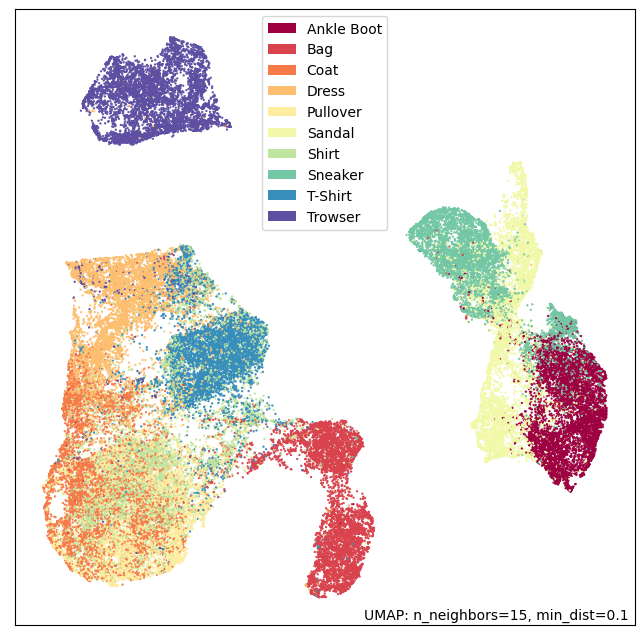

In [47]:
mapper = umap.UMAP().fit(pd.DataFrame(latent_repr.detach()))
umap.plot.points(mapper, labels=np.array(targets))

Analysis:

- 4 big clusters (pants, boots, tops, bags) pretty good seperated
- intra-cluster differences are 'ok':
  - some pairs are seperated good (T-Shirt vs Coat)
  - other are just all over the place (Shirt)

### 2.2 Interpolation in Latent Space

In [224]:
# Create the interpolations between to vectors
def get_interpolate_tensor(latents, start_img, end_img, steps=5):

    # Get first image
    df = pd.DataFrame(latents[start_img].detach()).T

    # Create interpolation vectors
    for _ in range(steps):
        df.loc[len(df)] = [None]*latents.shape[1]
    
    # Get second image
    df.loc[len(df)] = latents[end_img].detach().numpy()

    # Transform back to Tensor
    return torch.tensor(df.interpolate().values)

In [249]:
# Create (and show) the transition from one image to another
def make_interpolation_image(latents, start_img, end_img, file_name, steps=10, show=True):

    # Create decoded images
    interpolation_tensor = get_interpolate_tensor(latents, start_img, end_img, steps=steps)
    decoded = vae_model.decode(interpolation_tensor)

    # Create transition image
    grid = torchvision.utils.make_grid(decoded, nrow=decoded.shape[0])
    torchvision.utils.save_image(grid, f'{file_name}.png')

    # Display if needed
    if show:
        with open(f'{file_name}.png', 'rb') as f:
            display(Image.open(f))

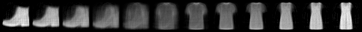

In [250]:
make_interpolation_image(latent_repr, 0, 4, 'tmp')

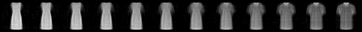

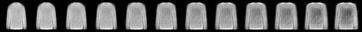

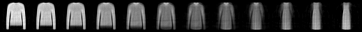

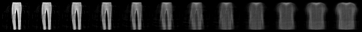

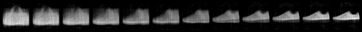

In [253]:
for _ in range(5):
    
    start_img = np.random.randint(0, latent_repr.shape[0])
    end_img   = np.random.randint(0, latent_repr.shape[0])

    make_interpolation_image(latent_repr, start_img, end_img, 'tmp')